# Análisis del riesgo de incumplimiento de los prestatarios por *Carlos Horta* (carlosgim@gmail.com)

---

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, se necesita predecir la cantidad de pedidos de taxis para la próxima hora. El objetivo de este proyecto es construir un modelo de predicción para cumplir con esta tarea.

La métrica utilizada para evaluar el rendimiento del modelo será el Root Mean Squared Error (RMSE) en el conjunto de prueba, y se establece un umbral máximo de 48 para dicha métrica.

## Instrucciones del proyecto

El proyecto se divide en las siguientes etapas:

1. Descarga de datos: Se debe descargar el archivo `taxi.csv` que contiene los datos históricos de los pedidos de taxis.
2. Remuestreo por hora: Los datos se encuentran en intervalos de tiempo más pequeños, por lo que es necesario realizar un remuestreo para tener la cantidad de pedidos de taxis por hora.
3. Análisis de datos: Se debe realizar un análisis exploratorio de los datos para comprender su distribución, identificar patrones y visualizar tendencias.
4. Entrenamiento de modelos: Se deben entrenar diferentes modelos utilizando diferentes conjuntos de hiperparámetros. Se recomienda utilizar una muestra de prueba que represente el 10% del conjunto de datos inicial.
5. Evaluación del modelo: Se debe evaluar el rendimiento de los modelos utilizando la muestra de prueba y la métrica de RMSE. Se debe comparar el RMSE obtenido con el umbral máximo establecido (48) para determinar si el modelo cumple con los requisitos del proyecto.
6. Conclusiones: Se deben proporcionar conclusiones sobre el rendimiento de los modelos y su capacidad para predecir la cantidad de pedidos de taxis para la próxima hora.

## Descripción de los datos

Los datos están almacenados en el archivo `taxi.csv`. La columna relevante para este proyecto es `num_orders`, que representa la cantidad de pedidos de taxis para cada intervalo de tiempo.

## Preparación

### Inicialización

In [1]:
# Es necesario cargar las diferentes librerías que se van a utilizar en el desarrollo del proyecto.

import math
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
from numpy.random import RandomState
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
# Se fijará la semilla para la reproducibilidad de los resultados.

rs = RandomState(1984)

### Carga de los datos

In [3]:
# Se cargan los datos de los ficheros csv en los dataframes correspondientes.

try: 
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [4]:
# Se obtienen los datos del dataframe.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Como se puede observar, el dataframe se compone de únicamente dos columnas: 'datetime' y 'num_orders'. La columna 'datetime' contiene la fecha y la hora en fracciones de 10 minutos, mientras que la columna 'num_orders' representa el número de solicitudes de taxis para cada intervalo de tiempo.

Los datos se encuentran completos, lo que significa que no hay valores faltantes en el dataframe. El siguiente paso en el proyecto es realizar el remuestreo de los datos por hora para obtener la cantidad de pedidos de taxis por hora.

Una vez completado el remuestreo, se procederá a realizar el análisis de los datos para comprender su distribución, identificar patrones y visualizar tendencias. Este análisis exploratorio de datos es fundamental para obtener información relevante y tomar decisiones informadas en la etapa de entrenamiento y evaluación de modelos.

In [6]:
# Se convierte la columna 'datetime' a tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Se establece 'datetime' como índice del DataFrame
df.set_index('datetime', inplace=True)

# Se remuestrea los datos por hora
df_hourly = df.resample('H').sum()

# Se verifica si los datos están ordenados cronológicamente
is_monotonic = df_hourly.index.is_monotonic
print("Los datos están ordenados cronológicamente:", is_monotonic)

Los datos están ordenados cronológicamente: True


Con los pasos anteriores, se han realizado las modificaciones necesarias para trabajar con series temporales. Ahora tenemos dos conjuntos de datos:

- 'df': Este conjunto de datos contiene la columna 'datetime' que ha sido convertida en un objeto de tipo datetime. Esto nos permitirá realizar análisis temporal más fácilmente y realizar operaciones basadas en fechas y horas.

- 'df_hourly': Este conjunto de datos representa los datos remuestreados a intervalos de una hora. Esto significa que ahora tenemos datos agregados por hora en lugar de datos a intervalos de 10 minutos. Este remuestreo nos permitirá tener una visión más general de la cantidad de pedidos de taxis por hora y facilitará el análisis y modelado de la serie temporal.

Ambos conjuntos de datos están ordenados de forma cronológica, lo que es fundamental para trabajar con series temporales.

## Análisis

En este apartado se revisarán algunas gráficos creados para revisar la distribución de los datos.

<AxesSubplot:xlabel='datetime'>

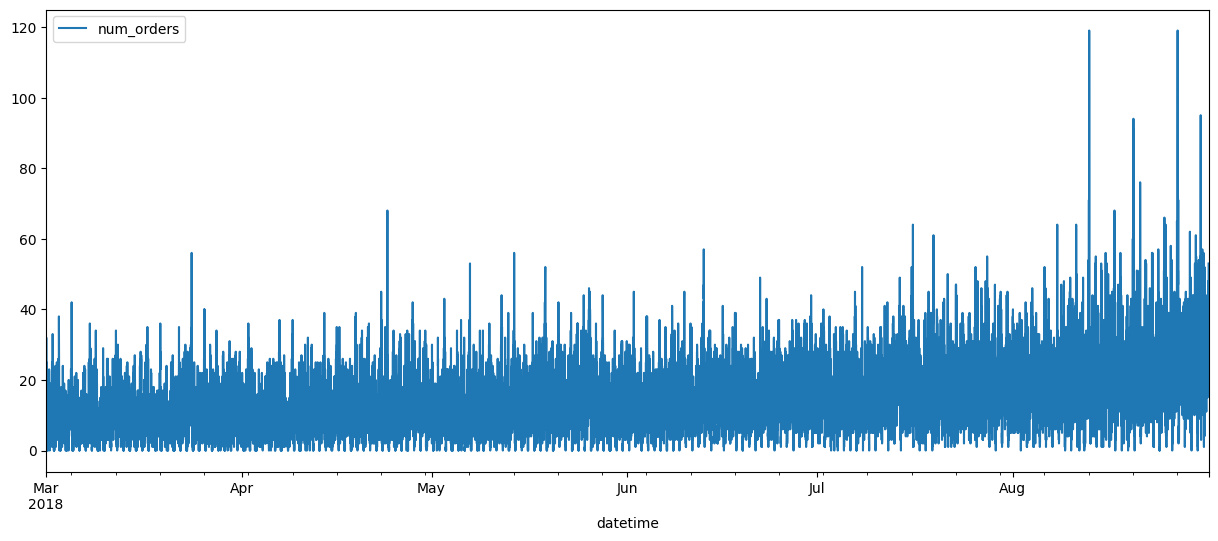

In [7]:
df.plot(y='num_orders', figsize=(15, 6))

<AxesSubplot:xlabel='datetime'>

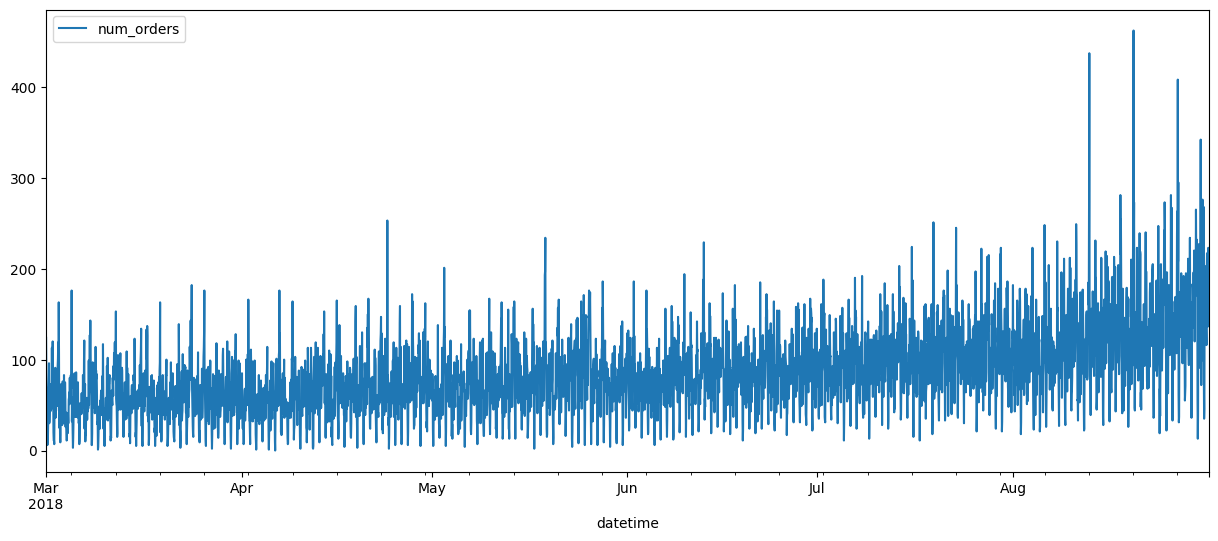

In [8]:
df_hourly.plot(y='num_orders', figsize=(15, 6))

El primer gráfico muestra la distribución de las solicitudes de taxi en intervalos de 10 minutos, mientras que el segundo gráfico muestra la agrupación por hora. Observamos que en el eje vertical, el máximo valor alcanza los 120 en el conjunto de datos original, mientras que en el conjunto de datos agrupados por hora, el valor máximo supera los 400.

Esto indica que el remuestreo por hora ha generado un conjunto de datos con valores más altos, lo que nos permite analizar las tendencias y patrones en una escala horaria más amplia. Esto puede ser útil para identificar las horas pico de demanda de taxis y planificar la asignación de recursos de manera más eficiente.

Con esta información, estamos preparados para realizar un análisis más detallado y construir modelos de predicción basados en la serie temporal de pedidos de taxis agrupados por hora.


### Media móvil 

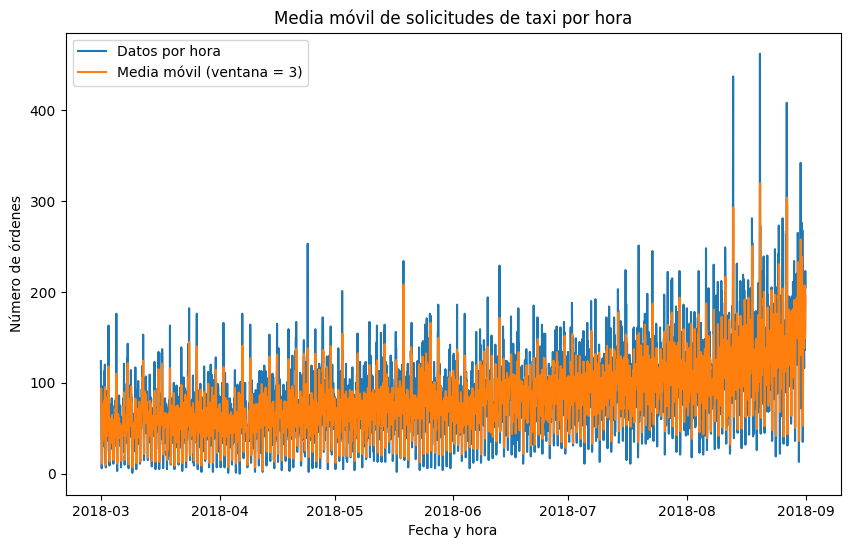

In [9]:
# Se calcula la media móvil con ventana de tamaño 3
rolling_mean = df_hourly['num_orders'].rolling(window=3).mean()

# Se crea el gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_hourly.index, df_hourly['num_orders'], label='Datos por hora')
plt.plot(df_hourly.index, rolling_mean, label='Media móvil (ventana = 3)')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de órdenes')
plt.title('Media móvil de solicitudes de taxi por hora')
plt.legend()
plt.show()


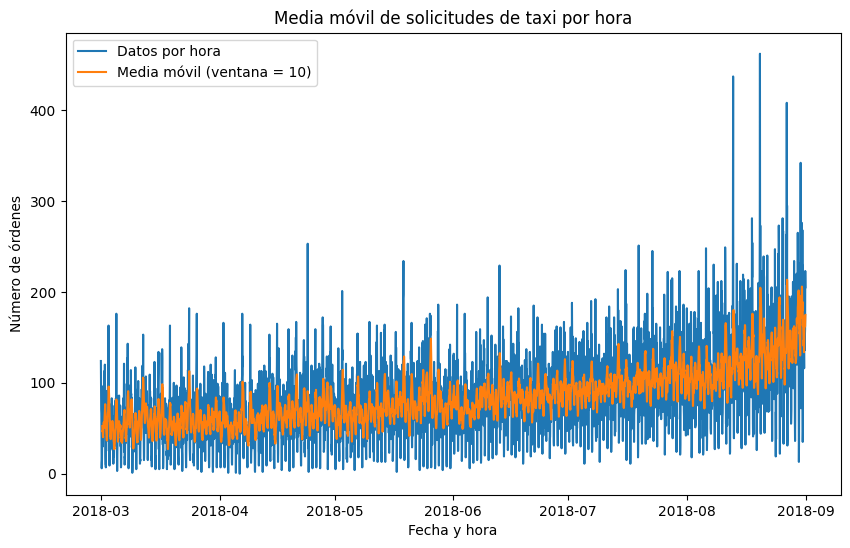

In [10]:
# Se calcula la media móvil con ventana de tamaño 10
rolling_mean = df_hourly['num_orders'].rolling(window=10).mean()

# Se crea el gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_hourly.index, df_hourly['num_orders'], label='Datos por hora')
plt.plot(df_hourly.index, rolling_mean, label='Media móvil (ventana = 10)')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de órdenes')
plt.title('Media móvil de solicitudes de taxi por hora')
plt.legend()
plt.show()

Como se puede apreciar en los gráficos anteriores, la media móvil proporciona una herramienta para experimentar con el intervalo de promediado. A medida que se aumenta el intervalo, el suavizado de la serie temporal se vuelve más pronunciado.

La media móvil actúa como un filtro que suaviza la serie al calcular el promedio de los valores en un intervalo determinado. Al ampliar el intervalo, se incluyen más puntos de datos en el cálculo de cada valor de la media móvil, lo que resulta en un suavizado más intenso de la serie.

El uso de la media móvil puede ser útil para eliminar el ruido y resaltar las tendencias subyacentes en los datos. Sin embargo, es importante tener en cuenta que al aumentar el intervalo de promediado, se puede perder información detallada sobre patrones más rápidos en la serie temporal.

### Tendencias y estacionalidad

#### Por hora

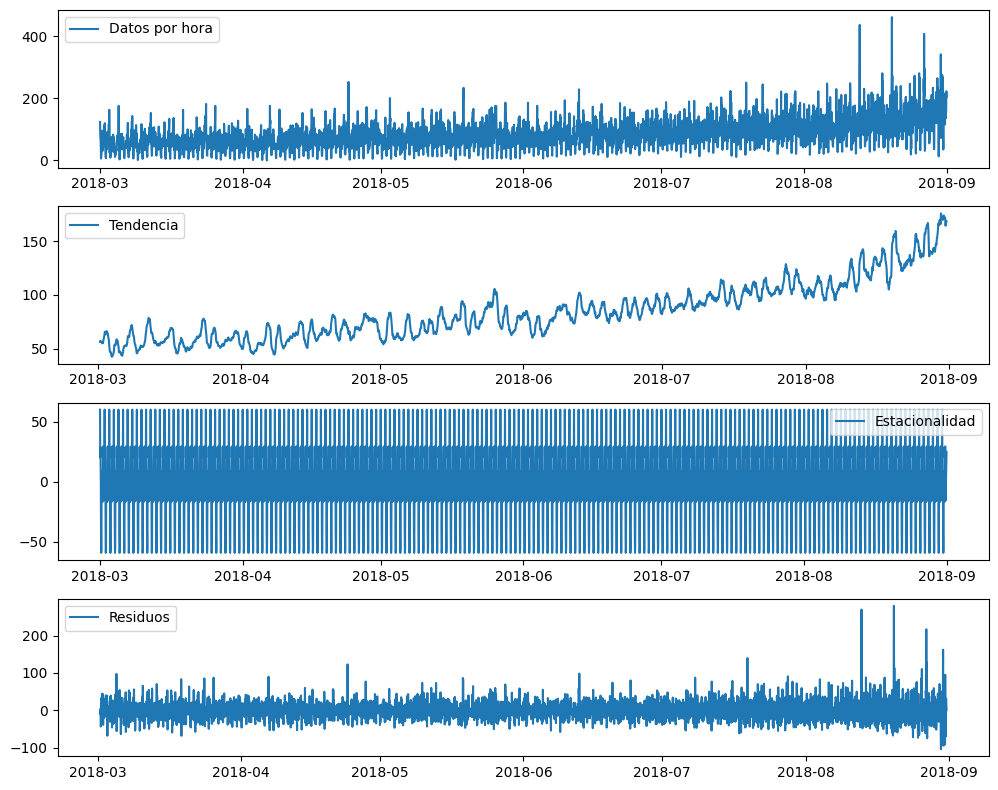

In [11]:
# Se aplica la descomposición estacional
decomposition = seasonal_decompose(df_hourly['num_orders'], model='additive')

# Se obtienen los componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Y se grafican los componentes
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df_hourly.index, df_hourly['num_orders'], label='Datos por hora')
plt.legend()

plt.subplot(412)
plt.plot(df_hourly.index, trend, label='Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(df_hourly.index, seasonal, label='Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(df_hourly.index, residual, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()


Al analizar el gráfico superior, se pueden identificar diferentes componentes de la serie temporal. En cuanto a la tendencia, se puede observar que presenta una clara tendencia ascendente a medida que avanzan los meses del año. Esto sugiere un crecimiento gradual en los datos a lo largo del tiempo.

En relación a la estacionalidad, al agrupar los datos por hora, no se observa un patrón particularmente notable. Esto podría indicar que la serie temporal no muestra una estacionalidad marcada en función de la hora del día. Sin embargo, es importante considerar que la estacionalidad podría ser más evidente si se agrupan los datos en intervalos de tiempo más amplios, como días o meses.

#### Por día

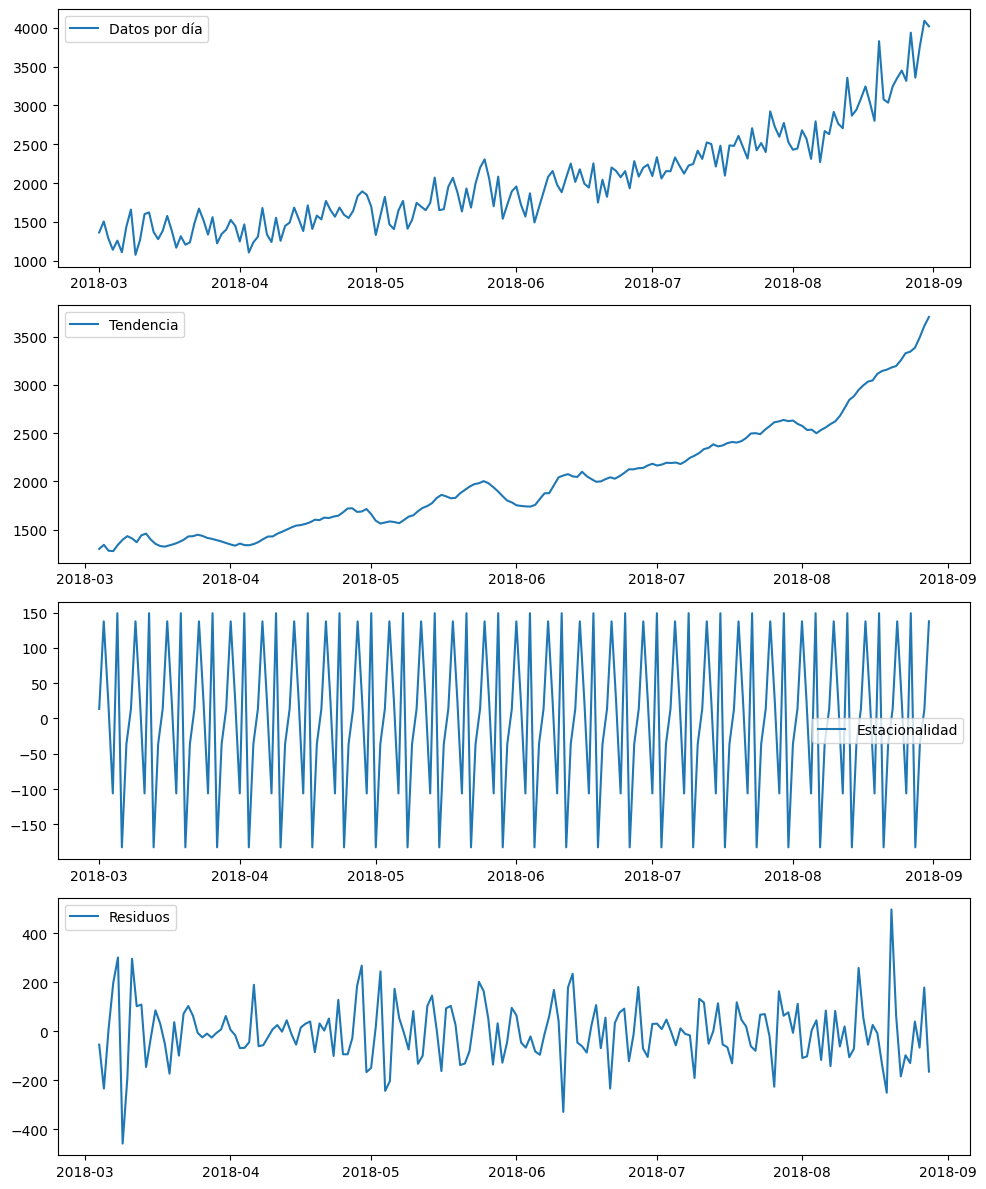

In [12]:
# Descomposición estacional por día
df_daily = df_hourly.resample('D').sum()  # Agrupamos los datos por día
decomposition_daily = seasonal_decompose(df_daily['num_orders'], model='additive')

# Obtenemos los componentes por día
trend_daily = decomposition_daily.trend
seasonal_daily = decomposition_daily.seasonal
residual_daily = decomposition_daily.resid

# Graficamos los componentes por día
plt.figure(figsize=(10, 12))

plt.subplot(411)
plt.plot(df_daily.index, df_daily['num_orders'], label='Datos por día')
plt.legend()

plt.subplot(412)
plt.plot(df_daily.index, trend_daily, label='Tendencia')
plt.legend()

plt.subplot(413)
plt.plot(df_daily.index, seasonal_daily, label='Estacionalidad')
plt.legend()

plt.subplot(414)
plt.plot(df_daily.index, residual_daily, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()

Si observamos la descomposición estacional por día en comparación con la descomposición por hora, podemos notar una mayor claridad en la estacionalidad y los residuos. Por ejemplo, al agrupar los datos por día, los valores de estacionalidad se ampliaron de 50/-50 (en la descomposición por hora) a 150/-150, lo que permite una visualización más clara de los patrones estacionales a lo largo de los días. Además, se hizo más evidente la tendencia de los datos al observar la descomposición por día.

En cuanto a los residuos, también experimentaron un cambio significativo al pasar de 200/-100 (en la descomposición por hora) a 400/-400 cuando se agruparon por día. Esta mayor amplitud en los residuos indica que después de separar la tendencia y la estacionalidad, aún quedan componentes irregulares más pronunciados. Estos residuos más amplios pueden ser el reflejo de la variación aleatoria no explicada por la descomposición y pueden requerir una mayor atención en el análisis de los datos.

En resumen, la descomposición estacional por día proporciona una representación más clara de la estacionalidad y permite identificar patrones diarios más evidentes. Además, los residuos ampliados destacan la variación irregular adicional que aún no ha sido capturada por la descomposición.

## Formación

In [13]:
# En este apartado se crearán las características que se utilizarán para entrenar los modelos de predicción, por ejemplo, la hora, el día de la semana, el mes, etc.

def make_features(data, max_lag, rolling_mean_size):
    # Se crean nuevas columnas para las características
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    # Se crean columnas de retraso (lag) utilizando un bucle
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Se crean columnas de media móvil utilizando el método rolling
    data['rolling_mean'] = data['num_orders'].shift().rolling(window=rolling_mean_size).mean()

    return data

# Se crean características en el DataFrame df_hourly
df_features = make_features(df_hourly, 4, 8)

df_features.head(5)

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN


In [14]:
# Se eliminarán las filas con valores nulos.

df_features.dropna(inplace=True)

## Características y objetivo

In [15]:
# Separamos los datos de testeo del resto de los datos
rest, test = train_test_split(df_features, shuffle=False, test_size=0.1)

# Creamos features y targets para entrenamiento
features_train = rest.drop('num_orders', axis=1)
targets_train = rest['num_orders']

# Creamos features y targets para testeo
features_test = test.drop('num_orders', axis=1)
targets_test = test['num_orders']

# Comprobemos el tamaño de los sets
print('Entrenamiento:')
print(features_train.shape)
print(targets_train.shape)
print()
print('Testeo')
print(features_test.shape)
print(targets_test.shape)


Entrenamiento:
(3967, 9)
(3967,)

Testeo
(441, 9)
(441,)


# Modelos

En esta sección, se explorarán diversos modelos con el objetivo de obtener el mejor modelo de predicción que cumpla con el requisito de tener un valor de la métrica RECM (Root Mean Squared Error) menor a 48. El RECM es una medida comúnmente utilizada para evaluar el rendimiento de los modelos de predicción, y en este caso, se establece un umbral de 48 como criterio para seleccionar el mejor modelo.

## Prueba de cordura con regresión lineal

In [16]:
# Prueba de cordura con regresión lineal

# Se crea el modelo
model = LinearRegression()
model.fit(features_train, targets_train)
reg_predictions = model.predict(features_test)
print('RMSE:', mean_squared_error(targets_test, reg_predictions, squared=False))

RMSE: 52.70704596484038


## Bosque aleatorio con ajuste de hiperparámetros

In [17]:
# Se definen los hiperparámetros a explorar
param_grid = {
    'max_depth': range(3, 8),
    'min_samples_leaf': range(3, 8)
}

# Se crea el modelo de Bosque Aleatorio
model = RandomForestRegressor(random_state=rs)

# Se crea el objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Se realiza la búsqueda de hiperparámetros
grid_search.fit(features_train, targets_train)

# Se obtiene los mejores parámetros y el mejor RMSE
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Se obtiene el mejor modelo a partir del objeto GridSearchCV
best_model = grid_search.best_estimator_

# Se realizan las predicciones con el mejor modelo en el conjunto de testeo
best_pred = best_model.predict(features_test)

# Se calcula el RMSE en el conjunto de testeo
score = mean_squared_error(targets_test, best_pred, squared=False)

print('Mejor ronda:', grid_search.best_index_ + 1)
print('Mejor RMSE:', score)
print('Mejores hiperparámetros:', best_params)


Mejor ronda: 22
Mejor RMSE: 50.14388156082982
Mejores hiperparámetros: {'max_depth': 7, 'min_samples_leaf': 4}


### CatBoost

In [18]:
# Se define el modelo de CatBoost
cat = CatBoostRegressor(silent=True)

# Y los hiperparámetros a explorar
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 300]
}

# Se crea el objeto GridSearchCV
grid_search = GridSearchCV(estimator=cat, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Se realiza la búsqueda de hiperparámetros
grid_search.fit(features_train, targets_train)

# Se obtienen los mejores parámetros y el mejor RMSE
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Se crea el mejor modelo con los mejores hiperparámetros encontrados
best_model = CatBoostRegressor(silent=True, **best_params)
best_model.fit(features_train, targets_train)

# Se realizan predicciones con el mejor modelo en el conjunto de testeo
best_pred = best_model.predict(features_test)

# Se calcula el RMSE en el conjunto de testeo
rmse_test = mean_squared_error(targets_test, best_pred, squared=False)

print('Mejor RMSE:', rmse_test)
print('Mejores hiperparámetros:', best_params)


Mejor RMSE: 45.011423251396025
Mejores hiperparámetros: {'depth': 4, 'learning_rate': 0.1, 'n_estimators': 300}


### LightGBM

In [19]:
# Definimos el modelo de LightGBM
lgbm = lgb.LGBMRegressor(random_state=rs)

# Y los hiperparámetros a explorar
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 300]
}

# Se crea el objeto GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Se realiza la búsqueda de hiperparámetros
grid_search.fit(features_train, targets_train)

# Y se obtienen los mejores parámetros y el mejor RMSE
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Se crea el mejor modelo con los mejores hiperparámetros encontrados
best_model = lgb.LGBMRegressor(random_state=rs, **best_params)
best_model.fit(features_train, targets_train)

# Se realizan predicciones con el mejor modelo en el conjunto de testeo
best_pred = best_model.predict(features_test)

# Y se calcula el RMSE en el conjunto de testeo
rmse_test = mean_squared_error(targets_test, best_pred, squared=False)

print('Mejor RMSE:', rmse_test)
print('Mejores hiperparámetros:', best_params)

Mejor RMSE: 43.00845673464775
Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 40}


| Modelo                             | RMSE                  |
| ---------------------------------- | --------------------- |
| Prueba de cordura con regresión lineal        | 52.70704596484038    |
| Bosque aleatorio con ajustes de hiperparámetros | 50.14388156082982    |
| CatBoost                           | 45.011423251396025    |
| LightGBM                           | 43.00845673464775     |

En el análisis de los diferentes modelos en términos de su rendimiento según el valor del RMSE, podemos observar lo siguiente:

El modelo de "Prueba de cordura con regresión lineal" obtuvo un RMSE de 52.707. Este valor indica un nivel de error relativamente alto en las predicciones. La regresión lineal no fue capaz de capturar de manera precisa la relación entre las variables de entrada y la variable objetivo.

El modelo de "Bosque aleatorio con ajustes de hiperparámetros" logró reducir el RMSE a 50.144. Aunque hubo una mejora en comparación con la regresión lineal, el valor todavía supera el umbral permitido de 48 para el proyecto.

El modelo de "CatBoost" mostró un RMSE de 45.011, lo cual representa una mejora adicional en comparación con el bosque aleatorio. CatBoost es capaz de manejar características categóricas de manera nativa y mostró un rendimiento prometedor.

El modelo de "LightGBM" obtuvo el menor RMSE de 43.008, esto indica un buen rendimiento y una capacidad para capturar patrones y relaciones en los datos.

En resumen, tanto "CatBoost" como "LightGBM" cumplen con el requisito de que la métrica RMSE en el conjunto de prueba no supere el valor de 48 establecido por el proyecto. Sin embargo, "LightGBM" muestra un mejor rendimiento con un valor de RMSE más bajo. Por lo tanto, "LightGBM" sería el modelo recomendado para utilizar en este proyecto, ya que presenta el mejor rendimiento en términos de precisión de las predicciones.